In [7]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === ƒê∆∞·ªùng d·∫´n t·ªõi th∆∞ m·ª•c ch·ª©a c√°c file txt ===
folder = "baseline_results"

data = []

for filename in os.listdir(folder):
    if not filename.endswith(".txt"):
        continue

    filepath = os.path.join(folder, filename)

    # T√°ch t√™n file theo template model_technique_task
    parts = filename.replace(".txt", "").split("_")
    if len(parts) >= 3:
        model = parts[0]
        task = parts[-1]
        technique = "_".join(parts[1:-1])
    else:
        continue

    with open(filepath, "r", encoding="utf-8") as f:
        content = f.read()

    # --- Ph√¢n lo·∫°i lo·∫°i k·∫øt qu·∫£ ---
    if "accuracy" in content or "precision" in content:  # classification_report
        # T√¨m accuracy trong ph·∫ßn b√°o c√°o
        match = re.search(r"accuracy\s+([\d\.]+)", content)
        accuracy = float(match.group(1)) if match else None
        data.append({
            "model": model,
            "technique": technique,
            "task": task,
            "metric": "accuracy",
            "value": accuracy
        })

    elif "MAE" in content:  # regression result
        match = re.search(r"MAE[:\s]+([\d\.]+)", content)
        mae = float(match.group(1)) if match else None
        data.append({
            "model": model,
            "technique": technique,
            "task": task,
            "metric": "MAE",
            "value": mae
        })

# === T·∫°o DataFrame t·ªïng h·ª£p ===
df = pd.DataFrame(data)
print(df)

# === L∆∞u l·∫°i n·∫øu c·∫ßn ===
df.to_csv("summary_results.csv", index=False)


    model            technique      task    metric        value
0    HDEM             int_anon  duration       MAE  2066.043815
1    HDEM                   sb  duration       MAE  2060.043815
2     KNN  hpcb_anon_template1   avgpcon       MAE    28.688500
3     KNN  hpcb_anon_template1  duration       MAE   203.766200
4     KNN  hpcb_anon_template1        ec  accuracy     0.840000
..    ...                  ...       ...       ...          ...
138   XGB    sb_anon_template6    pclass  accuracy     0.730000
139   XGB                   sb   avgpcon       MAE    36.293900
140   XGB                   sb  duration       MAE   461.284700
141   XGB                   sb        ec  accuracy     0.790000
142   XGB                   sb    pclass  accuracy     0.840000

[143 rows x 5 columns]


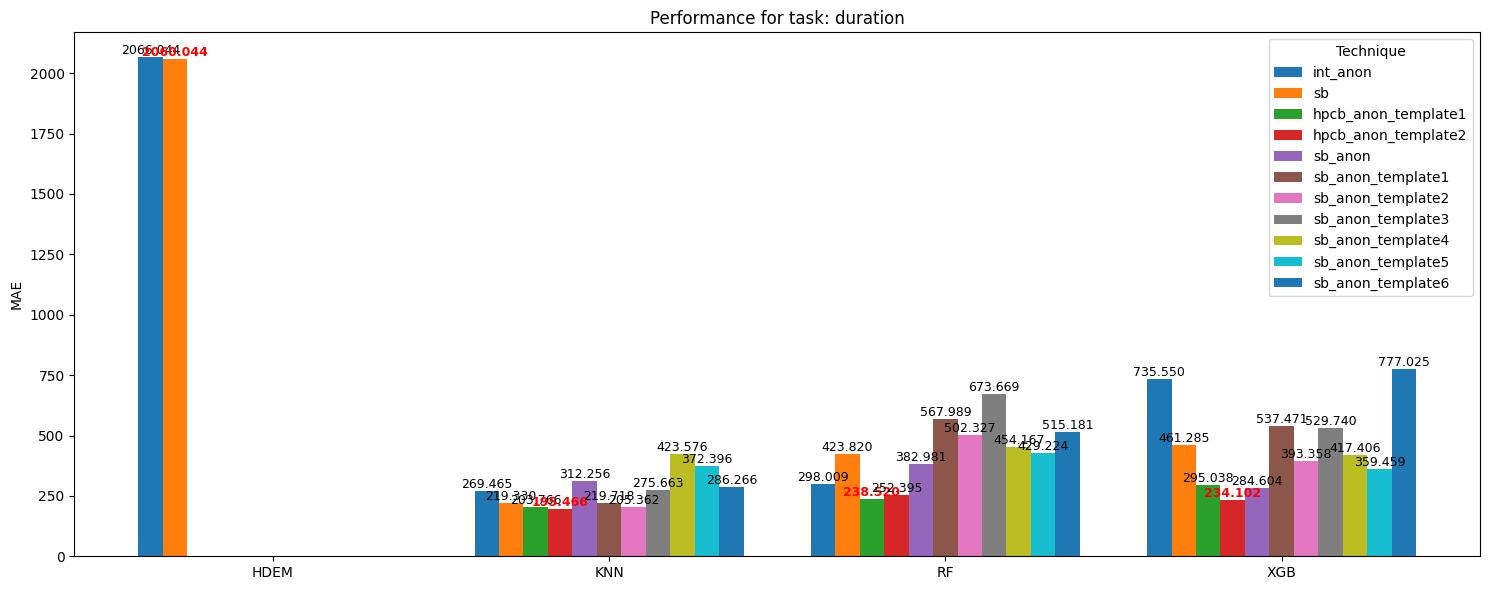

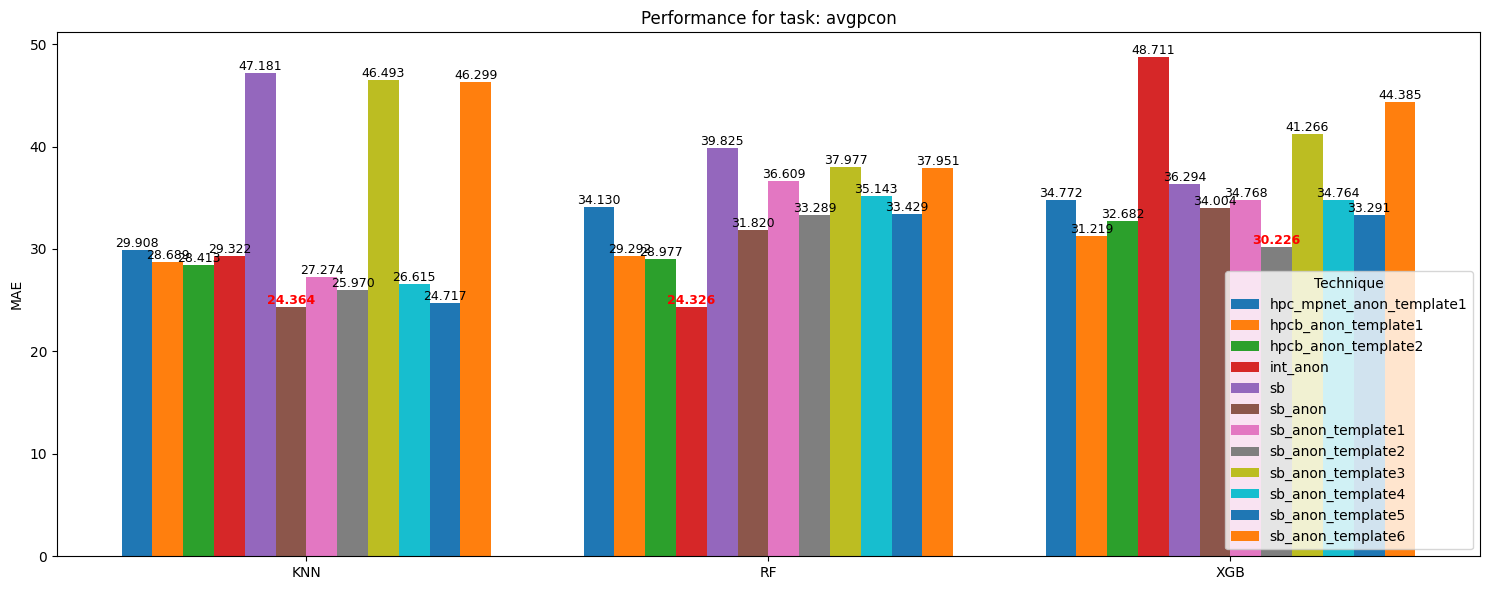

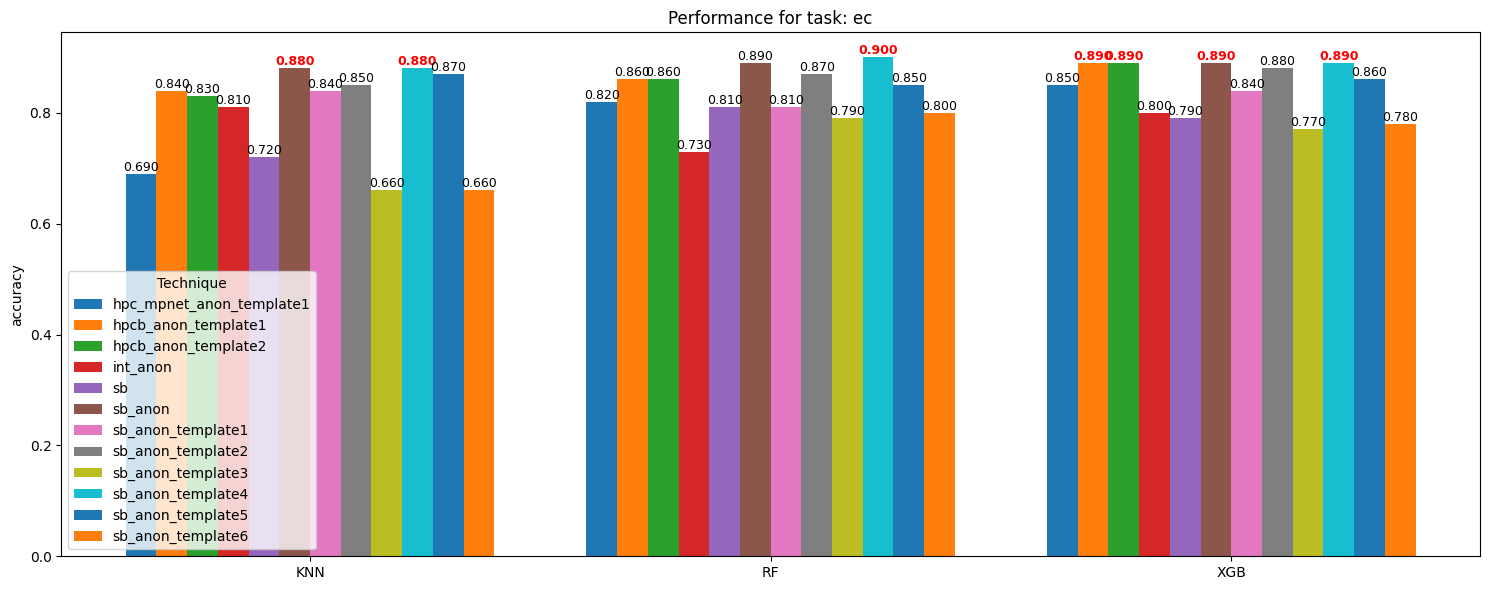

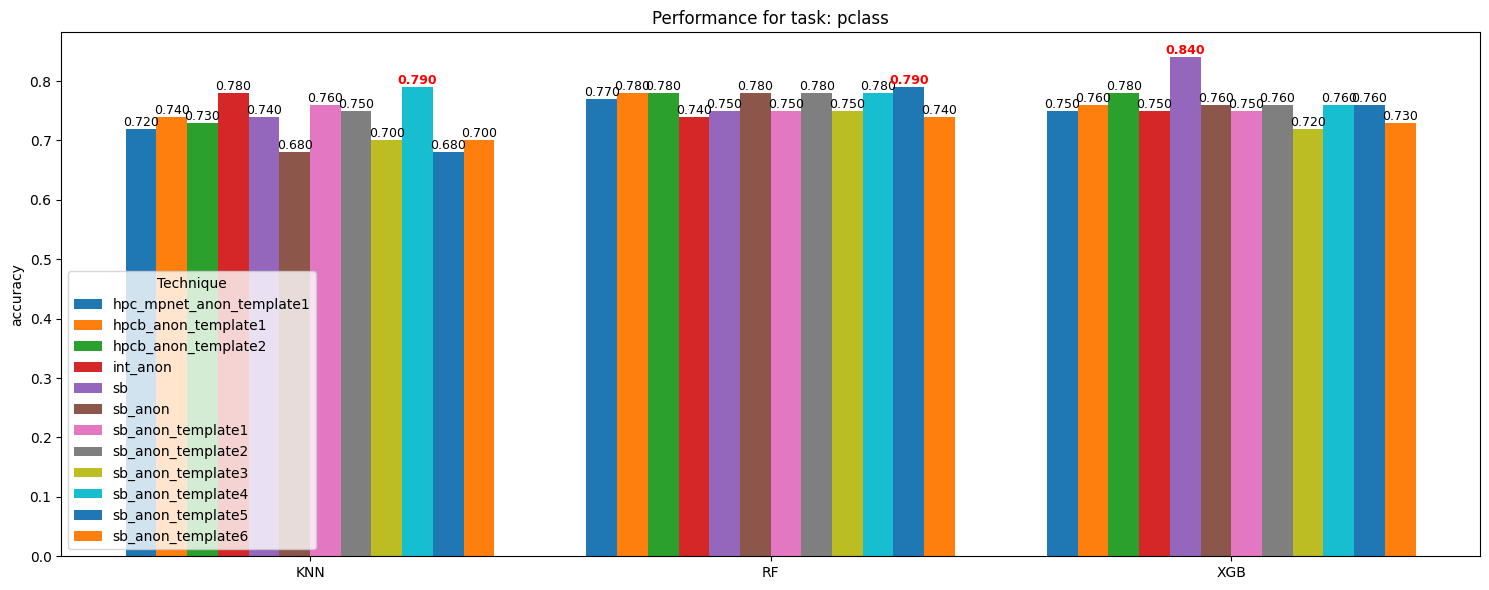

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# C√°c metric c·∫ßn MIN thay v√¨ MAX
minimize_metrics = {"mae", "rmse", "mse", "loss", "error"}

for task in df["task"].unique():
    subset = df[df["task"] == task].sort_values(["model", "technique"])

    models = subset["model"].unique()
    techniques = subset["technique"].unique()
    metric_name = subset["metric"].iloc[0].lower()

    x = np.arange(len(models))
    width = 0.8 / max(1, len(techniques))

    plt.figure(figsize=(15, 6))

    # Ch·ªçn h√†m min/max t√πy metric
    if any(m in metric_name for m in minimize_metrics):
        best_values = subset.groupby("model")["value"].min().to_dict()
        better = lambda val, best: np.isclose(val, best) or val <= best
    else:
        best_values = subset.groupby("model")["value"].max().to_dict()
        better = lambda val, best: np.isclose(val, best) or val >= best

    # V·∫Ω t·ª´ng technique (align values to full models list to avoid shape mismatch)
    for i, tech in enumerate(techniques):
        sub_t = subset[subset["technique"] == tech]
        # build values aligned to 'models' order; use np.nan for missing model-tech combos
        values = np.array([sub_t[sub_t["model"] == m]["value"].values[0]
                           if len(sub_t[sub_t["model"] == m]) > 0 else np.nan
                           for m in models])
        positions = x + (i - len(techniques)/2) * width + width/2
        bars = plt.bar(positions, values, width, label=tech)

        # G·∫Øn nh√£n; skip missing (NaN) entries to keep lengths consistent
        for bar, val, model in zip(bars, values, models):
            if np.isnan(val):
                continue
            height = bar.get_height()
            if better(val, best_values.get(model, val)):
                plt.text(
                    bar.get_x() + bar.get_width()/2,
                    height,
                    f"{height:.3f}",
                    ha="center", va="bottom",
                    fontsize=9, color="red", fontweight="bold"
                )
            else:
                plt.text(
                    bar.get_x() + bar.get_width()/2,
                    height,
                    f"{height:.3f}",
                    ha="center", va="bottom", fontsize=9
                )

    plt.xticks(x, models, rotation=0)
    plt.title(f"Performance for task: {task}")
    plt.ylabel(subset["metric"].iloc[0])
    plt.legend(title="Technique")
    plt.tight_layout()
    plt.show()


```python
semantic_templates = [
        # Template 1: C·∫•u tr√∫c b·ªã ƒë·ªông r√∫t g·ªçn (Compact Passive Construction)
        # Di·ªÖn ƒë·∫°t h√†nh ƒë·ªông ‚Äúsubmit‚Äù ·ªü d·∫°ng b·ªã ƒë·ªông nh·∫±m ƒëa d·∫°ng h√≥a ng·ªØ ph√°p v√† tr·∫≠t t·ª± th√¥ng tin.
        # C√¢u m√¥ t·∫£ ng·∫Øn g·ªçn, ƒë∆∞a "Job" l√™n ƒë·∫ßu ƒë·ªÉ nh·∫•n m·∫°nh ƒë·ªëi t∆∞·ª£ng c√¥ng vi·ªác, ƒë·ªìng th·ªùi v·∫´n gi·ªØ ƒë·ªß ba th·ª±c th·ªÉ: user ‚Äì job ‚Äì environment.
        lambda r: f"Job submitted by user {r['usr']} with name {r['jnam']} requiring environment {r['jobenv_req']}.",

        # Template 2: T·∫≠p trung v√†o Ch·ªß th·ªÉ/H√†nh ƒë·ªông c∆° b·∫£n (User‚ÄìJob‚ÄìEnvironment Relation)
        # M√¥ t·∫£ tr·ª±c ti·∫øp m·ªëi quan h·ªá gi·ªØa ng∆∞·ªùi d√πng (user), c√¥ng vi·ªác (job) v√† m√¥i tr∆∞·ªùng t√≠nh to√°n (environment).
        # C·∫•u tr√∫c ƒë∆°n gi·∫£n, d·ªÖ hi·ªÉu, gi√∫p m√¥ h√¨nh h·ªçc ƒë∆∞·ª£c ng·ªØ c·∫£nh c∆° b·∫£n c·ªßa h√†nh ƒë·ªông ‚Äúsubmit‚Äù.
        lambda r: f"The user profile {r['usr']} submitted a computation {r['jnam']} to the environment {r['jobenv_req']}.",
        
        # Template 3: T·∫≠p trung v√†o Ng·ªØ c·∫£nh/M√¥i tr∆∞·ªùng (Environment Focus)
        # Nh·∫•n m·∫°nh r·∫±ng m√¥i tr∆∞·ªùng ƒë∆∞·ª£c y√™u c·∫ßu cho m·ªôt t√°c v·ª• c·ª• th·ªÉ c·ªßa ng∆∞·ªùi d√πng.
        lambda r: f"The high-priority computational environment {r['jobenv_req']} was specifically requested by user {r['usr']} for running the job named {r['jnam']}.",
        
        # Template 4: T·∫≠p trung v√†o ƒê·ªëi t∆∞·ª£ng/C√¥ng vi·ªác (Job Focus)
        # Nh·∫•n m·∫°nh t√≠nh ch·∫•t c·ªßa Job v√† vai tr√≤ c·ªßa User/Environment ƒë·ªëi v·ªõi Job ƒë√≥.
        lambda r: f"Job {r['jnam']}, which will be executed by {r['usr']}, requires exclusive access to the infrastructure {r['jobenv_req']}.",
        
        # Template 5: M·ªëi quan h·ªá H√†nh ƒë·ªông & Li√™n k·∫øt (Action & Association)
        # D√πng c√°c ƒë·ªông t·ª´ m·∫°nh h∆°n ƒë·ªÉ m√¥ t·∫£ h√†nh ƒë·ªông l·∫≠p l·ªãch/ch·∫°y.
        lambda r: f"The scheduling system recorded that {r['usr']} is deploying job {r['jnam']} onto the {r['jobenv_req']} partition.",
        
        # Template 6: C√∫ ph√°p b·ªã ƒë·ªông (Passive Voice)
        # Th·ª≠ nghi·ªám c√°c c·∫•u tr√∫c c√¢u kh√°c ƒë·ªÉ bu·ªôc m√¥ h√¨nh h·ªçc c√°c ph·ª• thu·ªôc kh√°c.
        lambda r: f"The hardware configuration {r['jobenv_req']} is being utilized by job {r['jnam']} which was initialized by {r['usr']}."
    ]
```

üß† Task: avgpcon

| Model   | Template 2   | Template 4 | hpcb-template2 | hpcb-template4 |
| ------- | ------------ | ---------- | -------------- | -------------- |
| **KNN** | Top 3        | Top 4      | Top 6          | Top 5          |
| **RF**  | Top 3        | Top 5      | Top 3          | Top 2          |
| **XG**  | ü•á **Top 1** | Top 4      | Top 2          | Top 3          |


‚è±Ô∏è Task: duration

| Model   | Template 2   | Template 4 | hpcb-template2 | hpcb-template4 |
| ------- | ------------ | ---------- | -------------- | -------------- |
| **KNN** | ü•á **Top 1** | Top 9      | Top 2          | ü•á **Top 1**   |
| **RF**  | Top 6        | Top 5      | ü•á **Top 1**   | Top 2          |
| **XG**  | Top 3        | Top 4      | Top 3          | ü•á **Top 1**   |

‚ö° Task: ec

| Model   | Template 2   | Template 4 | hpcb-template2 | hpcb-template4 |
| ------- | ------------ | ---------- | -------------- | -------------- |
| **KNN** | Top 4        | ü•á **Top 1** | Top 5          | Top 7          |
| **RF**  | Top 3        | ü•á **Top 1** | Top 4          | Top 4          |
| **XG**  | Top 3        | ü•á **Top 1** | ü•á **Top 1**   | ü•á **Top 1**   |

üìä Task: pclass

| Model   | Template 2 | Template 4   | hpcb-template2 | hpcb-template4 |
| ------- | ---------- | ------------ | -------------- | -------------- |
| **KNN** | Top 4      | ü•á **Top 1** | Top 5          | Top 7          |
| **RF**  | Top 2      | Top 2        | Top 2          | Top 2          |
| **XG**  | Top 2      | Top 2        | Top 3           | Top 2        |